# Collaboration and Competition


### 1. Start the Environment

Import the necessary packages and start the Unity environment. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [4]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


### 4. Train the agents

Run the code below to solve the environment. 

After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.
This yields a single score for each episode.
The environment is considered solved, when the average (over 100 episodes) of those scores is at least +0.5.

In [5]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

# Initialise the two agents
agent1 = Agent(state_size=state_size, action_size=action_size, random_seed=2)
agent2 = Agent(state_size=state_size, action_size=action_size, random_seed=2) 

### 5. Implemenation details

In the **ddpg** function below we train two agents at the same time, based on the intuition that each agent receives its own
local observation.
Thus, we can easily adapt the code to simultaneously train both agents through self-play. 
Each agent uses the same actor network to select actions, and the experience is added to a shared replay buffer.

In [6]:
def ddpg(n_episodes=3000, max_t = 3000, update_every=5, num_learning_cycles=10):
    scores_deque = deque(maxlen=100)
    scores = []   

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent1.reset()
        agent2.reset()
        scores_per_episode = np.zeros(num_agents)
        for t in range(max_t):
            # extract the state of each agent
            state1 = states[0]
            state2 = states[1]
            # reshape each state and input into act method of agent1
            state1 = state1.reshape((1,states.shape[1]))
            state2 = state2.reshape((1,states.shape[1]))
            action1 = agent1.act(state1)
            action2 = agent1.act(state2)
            # send actions to the environment 
            env_info = env.step([action1, action2])[brain_name] 
            # get next states
            next_states = env_info.vector_observations   
            # get rewards
            rewards = env_info.rewards    
            # see if episodes finished
            dones = env_info.local_done                  
            
            # add experiences to shared replay memory
            for state, action, reward, next_state, done in zip(states, [action1, action2], rewards, next_states, dones):
                agent1.add_to_memory(state, action, reward, next_state, done)
                agent2.add_to_memory(state, action, reward, next_state, done)            
            
            # update the networks for 'num_learning_cycles' consecutive times every 'update_every' time steps
            if t % update_every == 0:
                for _ in range(num_learning_cycles):
                    agent1.step()
                    agent2.step()
                    
            # roll over states to next time step
            states = next_states
            #update the scores per episode
            scores_per_episode += rewards
            
            # exit loop if all episodes have completed
            if np.all(dones):
                break 
        
        score_max = np.max([scores_per_episode[0], scores_per_episode[1]])
        scores_deque.append(score_max)
        scores.append(score_max)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score_max), end="")
        if i_episode % 100 == 0:
            torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
            torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor_2.pth')
            torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic_2.pth')            
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
        if np.mean(scores_deque)>=0.5:
            print('\nEnvironment solved after {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
            torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor_2.pth')
            torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic_2.pth')
            break
    return scores


Episode 100	Average Score: 0.06	Score: 0.10
Episode 199	Average Score: 0.50	Score: 1.10
Environment solved after 199 episodes!	Average Score: 0.50


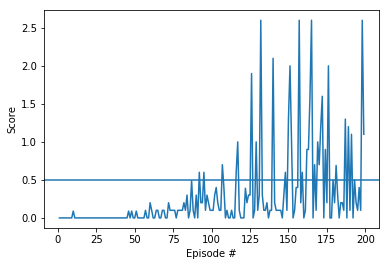

In [7]:
# execute the training routine
scores = ddpg()

# plot the results
fig = plt.figure()
ax = fig.add_subplot(111)
plt.axhline(y=0.5, xmin=0, xmax=len(scores)+1)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


### 8. Watch smart agents 

In [ ]:
agent1.actor_local.load_state_dict(torch.load('checkpoint_actor_1.pth'))
agent1.critic_local.load_state_dict(torch.load('checkpoint_critic_1.pth'))

agent2.actor_local.load_state_dict(torch.load('checkpoint_actor_2.pth'))
agent2.critic_local.load_state_dict(torch.load('checkpoint_critic_2.pth'))

for i in range(2):                                         # play game for 2 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        state1 = states[0].reshape((1,states.shape[1]))
        state2 = states[1].reshape((1,states.shape[1]))
        action1 = agent1.act(state1)
        action2 = agent2.act(state2)
        env_info = env.step([action1, action2])[brain_name] # send all actions to tne environment
        next_states = env_info.vector_observations          # get next state (for each agent)
        rewards = env_info.rewards                          # get reward (for each agent)
        dones = env_info.local_done                         # see if episode finished
        scores += env_info.rewards                          # update the score (for each agent)
        states = next_states                                # roll over states to next time step
        if np.any(dones):                                   # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))